In [1]:
import os
import pickle
import time

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import pandas as pd
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression

from collab.foraging import locust as lc
from collab.foraging import toolkit as ft
from collab.utils import find_repo_root

numpyro.set_platform("cpu")
root = find_repo_root()


smoke_test = "CI" in os.environ
subset_starts = 420
subset_ends = 430 if smoke_test else 480
desired_frames = 500 if smoke_test else 900
num_iterations = 50 if smoke_test else 2000
num_samples = 20 if smoke_test else 1000
sample_size = 100 if smoke_test else 1000
locust_sample_size = 100 if smoke_test else 10000


notebook_starts = time.time()

In [2]:
# 1800 seconds overall

locust_data_path = os.path.join(root, "data/foraging/locust/15EQ20191202_tracked.csv")

df = lc.load_and_clean_locust(
    path=locust_data_path,
    desired_frames=desired_frames,
    grid_size=45,
    rewards_x=[0.68074, -0.69292],
    rewards_y=[-0.03068, -0.03068],
    subset_starts=subset_starts,
    subset_ends=subset_ends,
)

loc_subset = df["subset"]
loc_all = df["all_frames"]

original_frames: 45000
original_shape: (675000, 4)
resulting_frames: 500
resulting_shape: (7500, 4)
min_time 1
max_time 500


In [3]:
# uncomment this if you're interested in processing the whole dataset
# instead of the subsample

# start_time = time.time()
# loc_all = ft.derive_predictors(loc_all, sampling_rate= .1)
# end_time = time.time()
# print("time taken", end_time - start_time)
# takes about 5 minutes to process the whole dataset
# with sampling rate .1

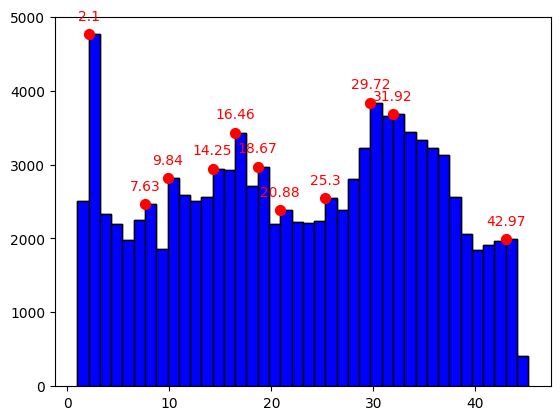

In [4]:
locust_distances = ft.foragers_to_forager_distances(loc_all.foragers)

# if you only care about distances in the subset
# locust_distances = ft.foragers_to_forager_distances(loc_subset.foragers)

distancesDF = pd.concat(locust_distances)
distancesDF.shape

distances_list = distancesDF.values.ravel().tolist()

distances_list = list(filter(lambda x: x != 0, distances_list))

hist, bins, _ = plt.hist(distances_list, bins=40, color="blue", edgecolor="black")
peaks, _ = find_peaks(hist)

plt.hist(distances_list, bins=40, color="blue", edgecolor="black")
plt.scatter(bins[peaks], hist[peaks], c="red", marker="o", s=50, label="Peaks")

peak_values = hist[peaks]
peak_positions = np.round(bins[peaks], 2)

for i, peak_x in enumerate(bins[peaks]):
    plt.annotate(
        f"{peak_positions[i]}",
        (peak_x, hist[peaks][i]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=10,
        color="red",
    )

# this suggests there is no proximity minimum other than what's excluded by physical overlap
# and that a decent guess for optimal proximity is around 2.11

Text(0.5, 1.0, 'Proximity score used in predictor derivation')

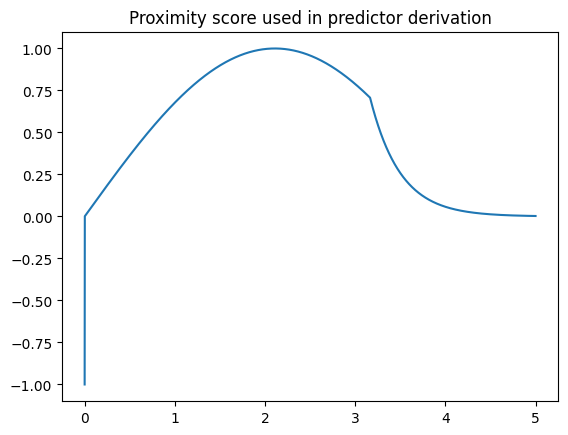

In [5]:
# this illustrates the proximity function that we will use
# in predictor derivation

start = 0.0
end = 5.0
step = 0.001
x = [start + i * step for i in range(int((end - start) / step) + 1)]
y = [
    ft.proximity_score(_d, getting_worse=0.0001, optimal=2.11, proximity_decay=3)
    for _d in x
]
plt.plot(x, y)
plt.title("Proximity score used in predictor derivation")

In [6]:
loc_subset = ft.derive_predictors(
    loc_subset,
    rewards_decay=0.4,
    visibility_range=90,
    getting_worse=0.001,
    optimal=2.11,
    proximity_decay=3,
    generate_communicates_indicator=True,
    info_time_decay=10,
    info_spatial_decay=0.1,
    finders_tolerance=2,
    time_shift=subset_starts - 1,
    sampling_rate=0.1,
    restrict_to_invisible=False,
)

2023-12-15 19:04:01,343 - traces done
2023-12-15 19:04:01,545 - visibility done
2023-12-15 19:04:02,580 - proximity done
2023-12-15 19:04:02,663 - how_far done
2023-12-15 19:04:02,683 - derivedDF done
2023-12-15 19:04:02,684 - starting to generate communicates
2023-12-15 19:04:03,941 - communicates done


In [7]:
ft.animate_foragers(
    loc_subset,
    plot_rewards=True,
    width=600,
    height=600,
    point_size=10,
    plot_communicate=1,
    plot_traces=True,
    trace_multiplier=15,
    communicate_multiplier=1,
)

In [8]:
loc_subset_robust = ft.prep_data_for_robust_inference(
    loc_subset, gridsize=9
)  # modifies loc_subset in place as well

In [9]:
data = ft.get_tensorized_data(loc_subset)

proximity, trace, visibility, communicate, how_far = (
    data["proximity_standardized"],
    data["trace_standardized"],
    data["visibility"],
    data["communicate_standardized"],
    data["how_far"],
)

ft.visualise_forager_predictors(trace, proximity, how_far, com=communicate)

Initial dataset size: 26664
Complete cases: 26664


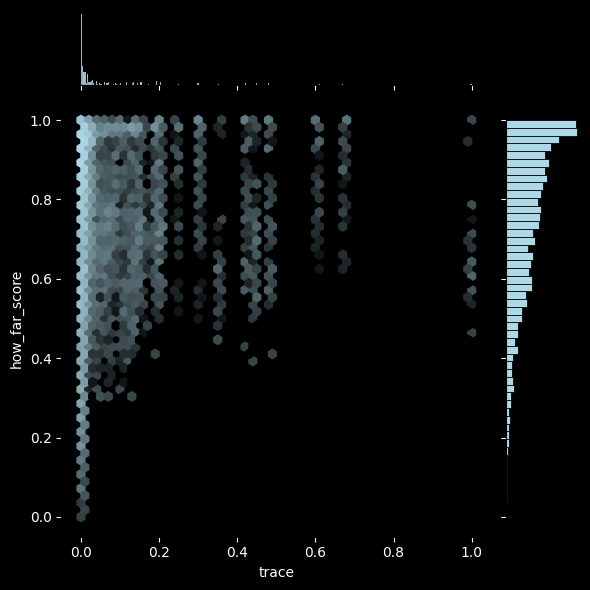

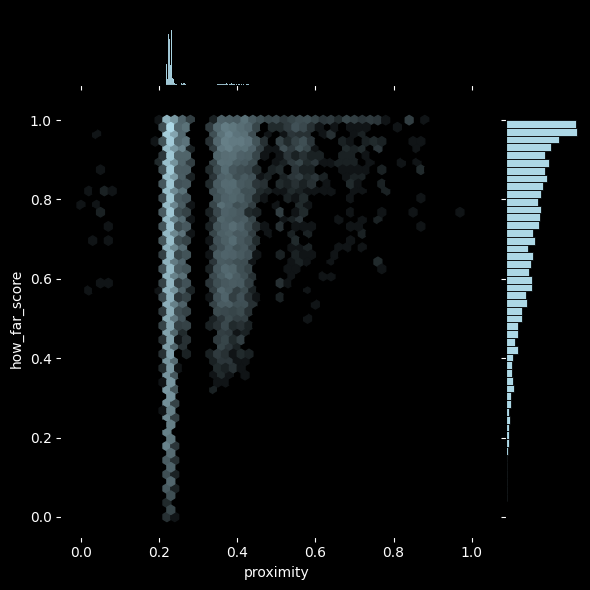

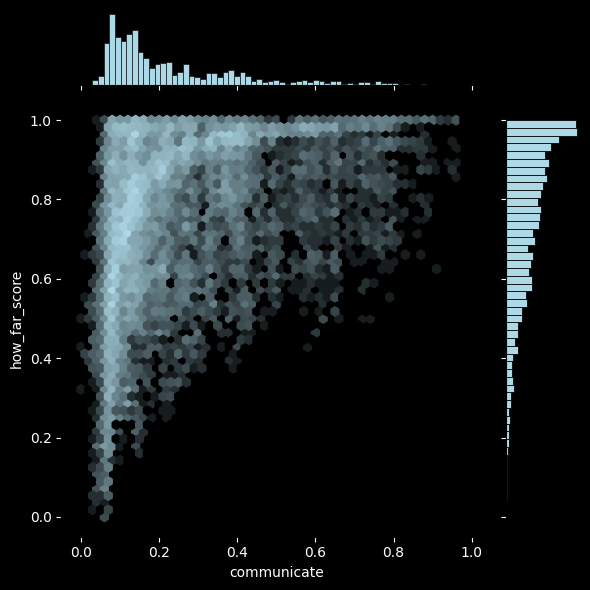

In [10]:
# alternative visualisation
x_to_plot = [trace, proximity, communicate]
x_labels = ["trace", "proximity", "communicate"]
y = how_far

# if seaborn gives deprecation warnings, here's a hacky fix
# import warnings
# warnings.simplefilter(action="ignore", category=FutureWarning)

Colors = ["black", "lightblue"]
cmap = colors.LinearSegmentedColormap.from_list("blackToBlue", Colors)

for idx, x in enumerate(x_to_plot):
    # Create the jointplot
    g = sns.jointplot(
        x=x,
        y=y,
        kind="hex",
        gridsize=50,
        cmap=cmap,
        norm=colors.LogNorm(),
        joint_kws=dict(facecolor="k"),
        marginal_kws=dict(facecolor="lightblue", edgecolor="black"),
    )

    # Set the main plot and marginal histograms background to black
    g.ax_joint.set_facecolor("black")
    g.ax_marg_x.set_facecolor("black")
    g.ax_marg_y.set_facecolor("black")

    # Set the background of the entire figure to black
    g.fig.set_facecolor("black")

    # Set axis labels
    g.set_axis_labels(x_labels[idx], "how_far_score", color="white")

    # Set tick labels to white for visibility against the black background
    g.ax_joint.tick_params(axis="both", colors="white")
    g.ax_marg_x.tick_params(axis="x", colors="white")
    g.ax_marg_y.tick_params(axis="y", colors="white")

    plt.show()

In [11]:
locust = loc_subset.derivedDF

locust["proximity_id"] = locust.proximity_cat.astype("category").cat.codes
locust["trace_id"] = locust.trace_cat.astype("category").cat.codes
locust["communicate_id"] = locust.communicate_cat.astype("category").cat.codes
locust["how_far"] = locust.how_far_squared_scaled

In [12]:
locust_sample_size = locust_sample_size
locust_subsample = locust.sample(n=locust_sample_size, random_state=42)


def list_empty_categories(column):
    return list(column.cat.categories[column.value_counts().eq(0)].values)


columns_to_clean_categories = ["proximity_id", "trace_id", "communicate_id"]

missing_categories = {}
locust_tensorized = {}
for column in columns_to_clean_categories:
    locust_subsample[column] = locust_subsample.proximity_cat.astype("category")
    missing_categories[column] = list_empty_categories(locust_subsample[column])
    locust_subsample[column] = locust_subsample[column].cat.remove_unused_categories()
    locust_subsample[column] = locust_subsample[column].cat.codes.values

    locust_tensorized[column] = torch.tensor(
        locust_subsample[column].values, dtype=torch.int32
    )

locust_tensorized["how_far"] = torch.tensor(
    locust_subsample["how_far"].values, dtype=torch.float32
)
locust_tensorized["proximity"] = torch.tensor(
    locust_subsample["proximity_standardized"].values, dtype=torch.float32
)
locust_tensorized["trace"] = torch.tensor(
    locust_subsample["trace_standardized"].values, dtype=torch.float32
)
locust_tensorized["communicate"] = torch.tensor(
    locust_subsample["communicate_standardized"].values, dtype=torch.float32
)

In [13]:
how_far_tensor = locust_tensorized["how_far"]
proximity_id_tensor = locust_tensorized["proximity_id"]
communicate_id_tensor = locust_tensorized["communicate_id"]
trace_id_tensor = locust_tensorized["trace_id"]


print("how_far_shape", how_far_tensor.shape)


def discretized_p(
    proximity_id_tensor, trace_id_tensor, communicate_id_tensor, how_far_tensor
):
    proximity_plate = pyro.plate(
        "proximity", len(torch.unique(proximity_id_tensor)), dim=-1
    )
    trace_plate = pyro.plate("trace", len(torch.unique(trace_id_tensor)), dim=-2)
    communicate_plate = pyro.plate(
        "communicate", len(torch.unique(communicate_id_tensor)), dim=-3
    )
    data_plate = pyro.plate("data", len(how_far_tensor), dim=-4)

    bias = pyro.sample("bias", dist.Normal(0.5, 0.3))

    with proximity_plate:
        p = pyro.sample("p", dist.Normal(0.0, 0.2))

    with trace_plate:
        t = pyro.sample("t", dist.Normal(0.0, 0.2))

    with communicate_plate:
        c = pyro.sample("c", dist.Normal(0.0, 0.2))

    with proximity_plate, trace_plate, communicate_plate:
        sigma = pyro.sample("sigma", dist.Exponential(7))

        mean = pyro.deterministic(
            "mean", bias + torch.einsum("...p,...td,...cdd->...ptc", p, t, c)
        )

    with data_plate:
        how_far_observed = pyro.sample(
            "how_far_observed",
            dist.Normal(
                mean[..., proximity_id_tensor, trace_id_tensor, communicate_id_tensor],
                sigma[..., proximity_id_tensor, trace_id_tensor, communicate_id_tensor],
            ),
            obs=how_far_tensor,
        )

how_far_shape torch.Size([100])


Step 0/50, Loss: 15585.833641648293


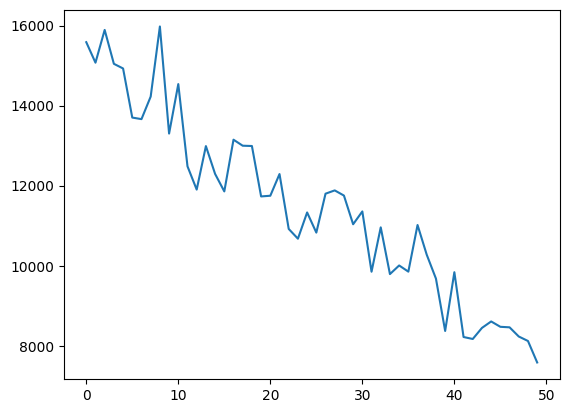

In [14]:
pyro.clear_param_store

guide = pyro.infer.autoguide.AutoNormal(discretized_p)
Adam = pyro.optim.Adam
Trace_ELBO = pyro.infer.Trace_ELBO
SVI = pyro.infer.SVI

pyro.clear_param_store()
svi = SVI(model=discretized_p, guide=guide, optim=Adam({"lr": 0.01}), loss=Trace_ELBO())


losses = []
num_steps = num_iterations
for step in range(num_steps):
    loss = svi.step(
        proximity_id_tensor, trace_id_tensor, communicate_id_tensor, how_far_tensor
    )
    losses.append(loss)
    if step % 100 == 0:
        print(f"Step {step}/{num_steps}, Loss: {loss}")

plt.plot(losses)

In [24]:
sites = ["p", "t", "c"]

num_samples = num_samples
predictive = pyro.infer.Predictive(
    model=discretized_p, guide=guide, num_samples=num_samples, return_sites=sites
)

samples_discrete = predictive(
    proximity_id_tensor, trace_id_tensor, communicate_id_tensor, how_far_tensor
)

locust_data_folder = os.path.join(root, "data/foraging/locust/")
discrete_samples_path = os.path.join(
    locust_data_folder,
    f"discrete_model_samples_iter{num_iterations}_lsamples{locust_sample_size}.pkl",
)
print(discrete_samples_path)
if not smoke_test:
    with open(discrete_samples_path, "wb") as f:
        pickle.dump(samples_discrete, f)

/home/rafal/s78projects/collaborative-intelligence/data/foraging/locust/discrete_model_samples_iter50_lsamples100.pkl


In [25]:
if not smoke_test:
    with open(discrete_samples_path, "rb") as f:
        samples_discrete = pickle.load(f)


In [26]:

# prep samples for visualisation and downstream analysis
parameters = ["p", "t", "c"]
parameter_samples = {}
for parameter in parameters:
    parameter_samples[parameter] = samples_discrete[parameter].squeeze()
    parameter_samples[f"raw_{parameter}_df"] = pd.DataFrame(
        parameter_samples[parameter]
    )
    num_categories = parameter_samples[parameter].shape[1]
    parameter_samples[f"{parameter}_df"] = {}
    for category in range(num_categories):
        parameter_samples[f"{parameter}_df"][category] = parameter_samples[parameter][
            :, category
        ].numpy()
    parameter_samples[f"{parameter}_df"] = pd.DataFrame(
        parameter_samples[f"{parameter}_df"]
    )
    parameter_samples[f"{parameter}_means"] = parameter_samples[f"{parameter}_df"].mean(
        axis=0
    )
    parameter_samples[f"{parameter}_stds"] = parameter_samples[f"{parameter}_df"].std(
        axis=0
    )

# add raw data stds
parameter_samples[f"data_p_stds"] = locust_subsample.groupby("proximity_id")[
    "how_far"
].std()
parameter_samples[f"data_t_stds"] = locust_subsample.groupby("trace_id")[
    "how_far"
].std()
parameter_samples[f"data_c_stds"] = locust_subsample.groupby("communicate_id")[
    "how_far"
].std()

# add raw data counts
parameter_samples[f"data_p_counts"] = locust_subsample["proximity_id"].value_counts()
parameter_samples[f"data_t_counts"] = locust_subsample["trace_id"].value_counts()
parameter_samples[f"data_c_counts"] = locust_subsample["communicate_id"].value_counts()

In [27]:
lrs = {}
X_new = np.arange(0, 9.1, 0.1).reshape((-1, 1))
linear_preds = {}

for par in parameters:
    means = parameter_samples[f"{par}_means"]
    stds = parameter_samples[f"{par}_stds"]
    data_stds = parameter_samples[f"data_{par}_stds"]
    if np.any(data_stds.isna()):
        print("Found nans in stds, increase sample size!")
    mean_stds = np.nanmean(data_stds)
    data_stds.fillna(mean_stds, inplace=True)
    data_counts = parameter_samples[f"data_{par}_counts"]
    lrs[par] = LinearRegression()
    lrs[par].fit(
        np.arange(len(means)).reshape(-1, 1),
        means,
        sample_weight=1 / (data_stds) * data_counts / sum(data_counts),
    )
    linear_preds[par] = lrs[par].predict(X_new)

Found nans in stds, increase sample size!
Found nans in stds, increase sample size!
Found nans in stds, increase sample size!


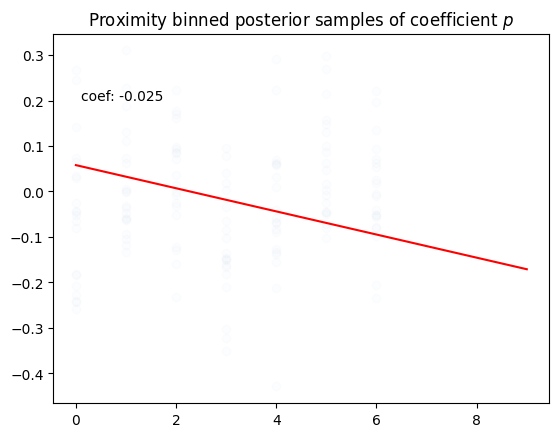

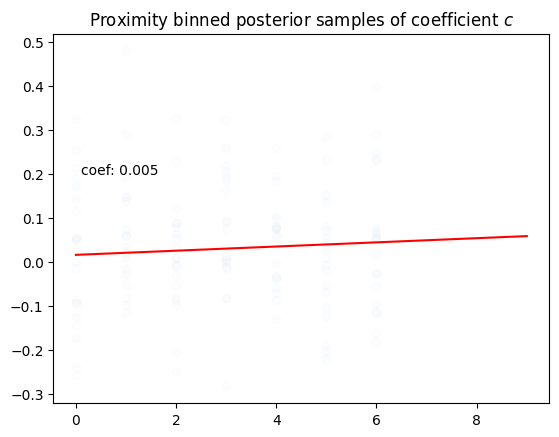

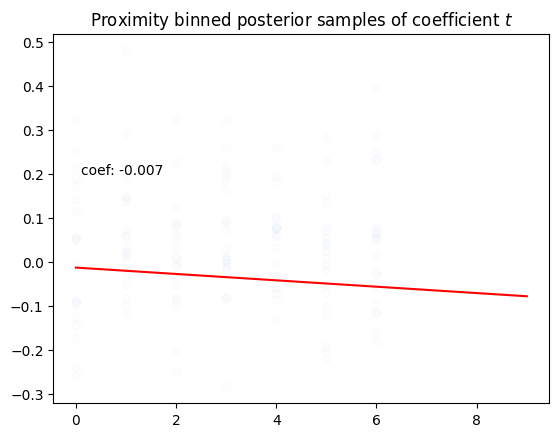

In [30]:
long_p = parameter_samples["raw_p_df"].melt()
coef = round(lrs["p"].coef_[0], 3)
plt.scatter(long_p.variable, long_p.value, alpha=0.01)
plt.title("Proximity binned posterior samples of coefficient $p$")
plt.text(0.1, 0.2, f"coef: {coef}")
plt.plot(X_new, linear_preds["p"], color="red", label="Linear Prediction")
plt.show()

long_c = parameter_samples["raw_c_df"].melt()
coef = round(lrs["c"].coef_[0], 3)
plt.scatter(long_c.variable, long_c.value, alpha=0.01)
plt.title("Proximity binned posterior samples of coefficient $c$")
plt.text(0.1, 0.2, f"coef: {coef}")
plt.plot(X_new, linear_preds["c"], color="red", label="Linear Prediction")
plt.show()

long_t = parameter_samples["raw_t_df"].melt()
coef = round(lrs["t"].coef_[0], 3)
plt.scatter(long_c.variable, long_c.value, alpha=0.01)
plt.title("Proximity binned posterior samples of coefficient $t$")
plt.text(0.1, 0.2, f"coef: {coef}")
plt.plot(X_new, linear_preds["t"], color="red", label="Linear Prediction")
plt.show()

In [31]:
how_far_tensor = locust_tensorized["how_far"]
proximity_tensor = locust_tensorized["proximity"]
communicate_tensor = locust_tensorized["communicate"]
trace_tensor = locust_tensorized["trace"]


def continuous_model(
    proximity_tensor, trace_tensor, communicate_tensor, how_far_tensor
):
    bias = pyro.sample("bias", dist.Normal(0.5, 0.3))
    p = pyro.sample("p", dist.Normal(0.0, 0.2))
    t = pyro.sample("t", dist.Normal(0.0, 0.2))
    c = pyro.sample("c", dist.Normal(0.0, 0.2))

    sigma_bias = pyro.sample("sigma_bias", dist.Exponential(7))
    p_sigma = pyro.sample("p_sigma", dist.Exponential(7))
    t_sigma = pyro.sample("t_sigma", dist.Exponential(7))
    c_sigma = pyro.sample("c_sigma", dist.Exponential(7))

    with pyro.plate("data", len(how_far_tensor)):
        sigma = pyro.deterministic(
            "sigma",
            sigma_bias
            + p_sigma * proximity_tensor
            + t_sigma * trace_tensor
            + c_sigma * communicate_tensor,
        )

        mean = pyro.deterministic(
            "mean",
            bias + p * proximity_tensor + t * trace_tensor + c * communicate_tensor,
        )

        how_far_observed = pyro.sample(
            "how_far_observed", dist.Normal(mean, sigma), obs=how_far_tensor
        )


Step 0/50, Loss: 949.6662404537201


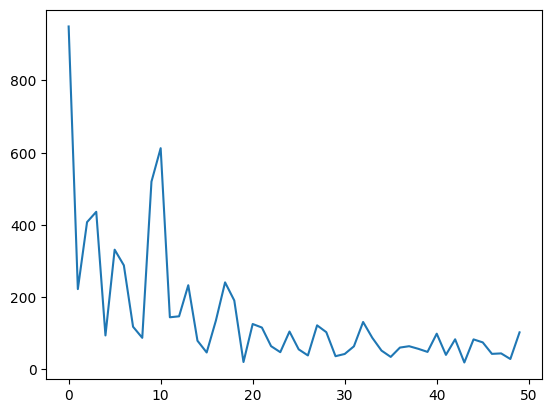

In [32]:
pyro.clear_param_store

guide_continuous = pyro.infer.autoguide.AutoDiagonalNormal(continuous_model)
Adam = pyro.optim.Adam
Trace_ELBO = pyro.infer.Trace_ELBO
SVI = pyro.infer.SVI

pyro.clear_param_store()
svi = SVI(
    model=continuous_model,
    guide=guide_continuous,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO(),
)


losses = []
num_steps = num_iterations
for step in range(num_steps):
    loss = svi.step(proximity_tensor, trace_tensor, communicate_tensor, how_far_tensor)
    losses.append(loss)
    if step % 100 == 0:
        print(f"Step {step}/{num_steps}, Loss: {loss}")

plt.plot(losses)

In [33]:
sites = ["p", "t", "c"]

num_samples = num_samples
predictive_continuous = pyro.infer.Predictive(
    model=continuous_model,
    guide=guide_continuous,
    num_samples=num_samples,
    return_sites=sites,
)

samples_continuous = predictive_continuous(
    proximity_tensor, trace_tensor, communicate_tensor, how_far_tensor
)

if not smoke_test:
    locust_data_folder = os.path.join(root, "data/foraging/locust/")
    locust_continuous_samples_path = os.path.join(
        locust_data_folder,
        "locust_cont__samples_iter{num_iterations}_lsamples{locust_sample_size}.pkl",
    )

    with open(locust_continuous_samples_path, "wb") as f:
        pickle.dump(samples_continuous, f)

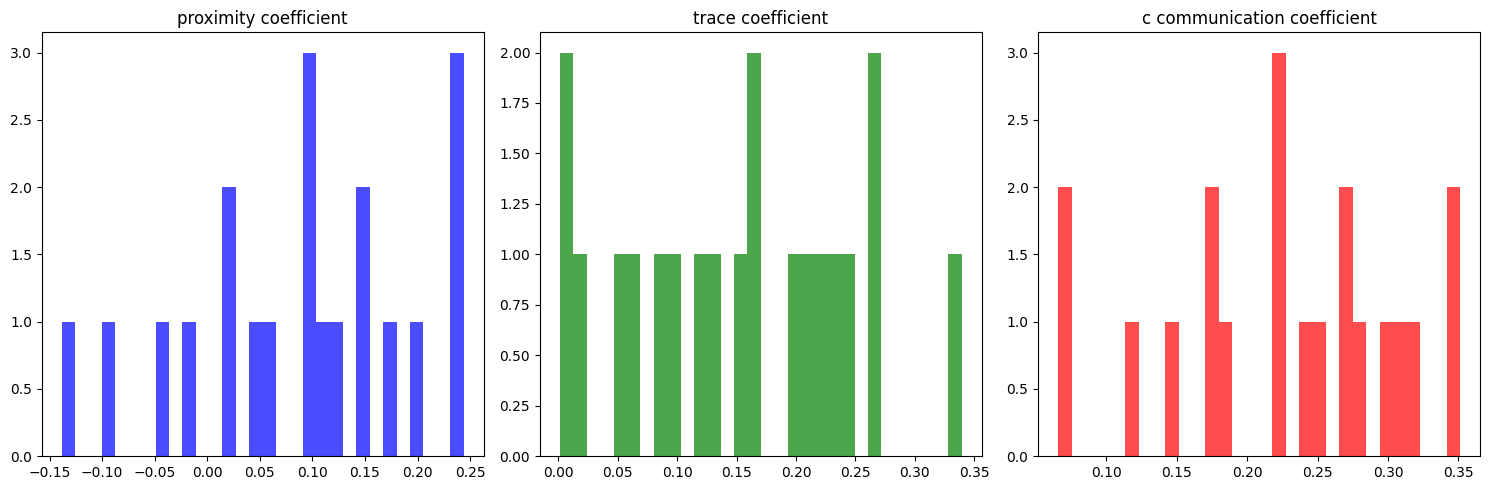

notebook took 225.6980345249176 seconds, that is  3.761633908748627 minutes to run
notebook took 225.69823479652405 seconds, that is  3.761637246608734 minutes to run


In [34]:
if not smoke_test:
    with open(locust_continuous_samples_path, "rb") as f:
        samples_continuous = pickle.load(f)


p_sam = samples_continuous["p"].squeeze()
t_sam = samples_continuous["t"].squeeze()
c_sam = samples_continuous["c"].squeeze()

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(p_sam, bins=30, color="blue", alpha=0.7)
plt.title("proximity coefficient")

plt.subplot(1, 3, 2)
plt.hist(t_sam, bins=30, color="green", alpha=0.7)
plt.title("trace coefficient")

plt.subplot(1, 3, 3)
plt.hist(c_sam, bins=30, color="red", alpha=0.7)
plt.title("c communication coefficient")

plt.tight_layout()
plt.show()


notebook_ends = time.time()
print(
    "notebook took",
    notebook_ends - notebook_starts,
    "seconds, that is ",
    (notebook_ends - notebook_starts) / 60,
    "minutes to run",
)

notebook_ends = time.time()
print(
    "notebook took",
    notebook_ends - notebook_starts,
    "seconds, that is ",
    (notebook_ends - notebook_starts) / 60,
    "minutes to run",)